In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
from pymc3.distributions.timeseries import EulerMaruyama

In [2]:
# to test whether pymc3 can be used we test it on a non-linear SDE
# that has an analytical solution Cox,Ingersol, Ross Econometrica 53,385-407(1985)
# dX = alpha(beta-X)dt + sigma*sqrt(X)dW
# model parameters:
alpha = 0.2
beta = 0.08
sigma = 0.03
dt = 1/12000 # 1000th of a year
N = 50000
t = np.arange(N+1)*dt

In [3]:
dW = np.random.normal(loc=0,scale=np.sqrt(dt),size=N)
X = [0.1]
for i,onedW in enumerate(dW):
    n = X[i] + alpha*(beta-X[i])*dt + sigma*np.sqrt(X[i])*onedW
    X.append(n)
X = np.array(X)

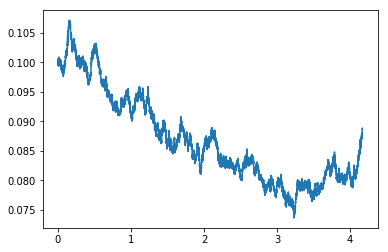

In [4]:
plt.plot(t,X)

In [5]:
with pm.Model() as model:

    Alpha = pm.Uniform('Alpha', 0,0.5)
    Beta  = pm.Uniform('Beta', 0,0.2)
    Sigma = pm.Uniform('Sigma',0,0.1)
    
def CIR_sde(x, Alpha, Beta,Sigma):
    return Alpha * (Beta-x),Sigma*np.sqrt(x)

with model:
    # hidden states following a OU SDE 
    XX = EulerMaruyama('XX',
                      dt,
                      CIR_sde,
                      (Alpha,Beta,Sigma),
                      shape=X.shape,
                      testval=np.zeros(shape=X.shape),
                     observed = X)
    
    trace = pm.sample(10000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Beta, Alpha]
Sampling 4 chains: 100%|██████████| 60000/60000 [02:21<00:00, 424.55draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.6782385264480154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5678644023925123, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Alpha,0.202987,0.144839,1.641102e-03,0.000017,0.460679,5930.458196,1.000362
Beta,0.079708,0.034374,2.907770e-04,0.000413,0.146904,11260.786149,0.999969
Sigma,0.029950,0.000095,8.444846e-07,0.029758,0.030127,12316.925610,1.000005


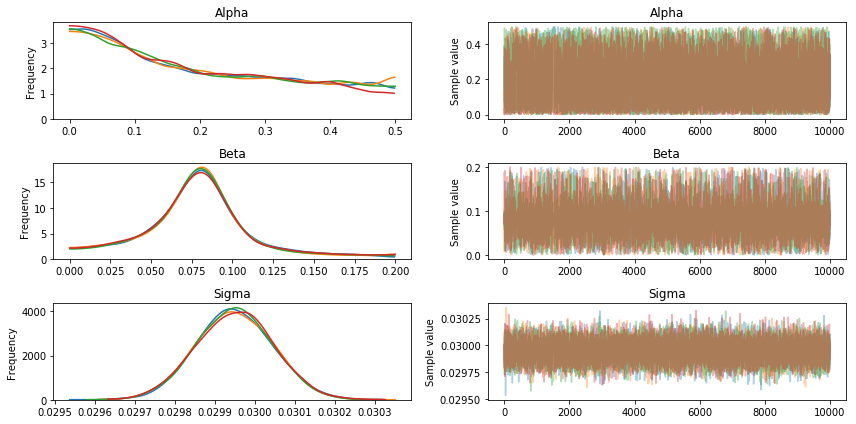

In [6]:
pm.traceplot(trace)
pm.summary(trace)

In [7]:
print(0.042411/np.sqrt(2))

0.029989105696902663
